In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as inte
from numpy import matmul as mm
from mpl_toolkits import mplot3d

### Reusable Functions

In [2]:
def quad_pos(pos,rot,L,H=.05):
    tmp = np.hstack((rot,pos))
    wHb = np.vstack((tmp,np.array([0,0,0,1])))
    quadBodyFrame = np.array([[L,0,0,1],
                             [0,L,0,1],
                             [-L,0,0,1],
                             [0,-L,0,1],
                             [0,0,0,1],
                             [0,0,H,1]]).T
    quadWorldFrame = mm(wHb,quadBodyFrame)
    quad = quadWorldFrame[:3,:]
    return quad
def QuatToRot(q):
    q = q/np.sqrt(np.sum(q**2))
    qahat = np.zeros((3,3))
    qahat[0,1],qahat[0,2] = -q[3],q[2]
    qahat[1,2],qahat[1,0] = -q[1],q[3]
    qahat[2,0],qahat[2,1] = -q[2],q[1]
    R = np.eye(3)+2*mm(qahat,qahat)+2*q[0]*qahat
    return R

### Modified Functions

In [3]:
def controller(state,des_state,params):
    u1,u2,dpc,d2pc = 0,0,0,0
    kvz,kpz,kvy,kpy,kvp,kpp = 100,180,10,10,17,140
    ey = des_state['pos'][0]-state['pos'][0]
    ez = des_state['pos'][1]-state['pos'][1]
    dey = des_state['vel'][0]-state['vel'][0]
    dez = des_state['vel'][1]-state['vel'][1]
    d2yd = des_state['acc'][0]
    d2zd = des_state['acc'][1]
    p,dp = state['rot'],state['omega']
    pc = -(d2yd+kvy*dey+kpy*ey)/params['gravity']
    dep,ep = dpc-dp,pc-p
    u1 = params['mass']*(params['gravity']+d2zd+kvz*dez+kpz*ez)
    u2 = params['Ixx']*(d2pc+kvp*dep+kpp*ep)
    return u1,u2

In [4]:
def sys_params():
    params = {}
    params['gravity'],params['mass'],params['arm_length']=9.81,.18,.086
    params['Ixx'],params['minF'] = .00025,0
    params['maxF'] = 2*params['mass']*params['gravity']
    return params
def simStateToQuadState(sim_state):
    quad_state = np.zeros((13,1))
    quad_state[0],quad_state[3],quad_state[12] = 0,0,0
    quad_state[8:11] = 0
    quad_state[1] = sim_state[0]
    quad_state[2] = sim_state[1]
    quad_state[4] = sim_state[3]
    quad_state[5] = sim_state[4]
    quad_state[11] = sim_state[5]
    quad_state[6] = np.cos(-sim_state[2]/2)
    quad_state[7] = np.sin(-sim_state[2]/2)
    return quad_state
def sys_eom(t,s,controlhandle,trajhandle,params):
    current_state = {}
    current_state['pos'] = s[:2]
    current_state['rot'] = s[2]
    current_state['vel'] = s[3:5]
    current_state['omega'] = s[5]
    desired_state = trajhandle(t)
    F,M = controlhandle(current_state,desired_state,params)
    u1 = .5*(F-M/params['arm_length'])
    u2 = .5*(F+M/params['arm_length'])
    u1_clamped = np.clip(u1,params['minF']/2,params['maxF']/2)
    u2_clamped = np.clip(u2,params['minF']/2,params['maxF']/2)
    F_clamped = u1_clamped + u2_clamped
    M_clamped = (u2_clamped-u1_clamped)*params['arm_length']
    sdot = np.array([[s[3]],[s[4]],[s[5]],
                    [-F_clamped*np.sin(s[2])/params['mass']],
                    [F_clamped*np.cos(s[2])/params['mass']-params['gravity']],
                    [M_clamped/params['Ixx']]])
    return sdot

### QuadPlot Class

In [5]:
class QuadPlot():
    def __init__(self,qn,state,wingspan,height,color,max_iter,h_3d=None):
        # public
        self.k,self.time = 0,0
        self.qn = qn
        self.state = state
        self.wingspan = wingspan
        self.color = color
        self.height = height
        self.rot = QuatToRot(self.state[6:10])
        self.motor = quad_pos(self.state[:3],self.rot,self.wingspan,self.height)
        self.max_iter = max_iter
        self.state_hist = np.zeros((6,max_iter))
        self.time_hist = np.zeros((1,max_iter))
        
        # private
        self.__text_dist = self.wingspan/3
        if h_3d is None:
            h_3d = plt.gca()
        self.__h_3d = h_3d
        self.__h_pos_hist = h_3d.plot3D(self.state[0],
                                        self.state[1],self.state[2],'r.')
        self.__h_m13 = h_3d.plot3D(self.motor[0,[0,2]],
                                  self.motor[1,[0,2]],
                                  self.motor[2,[0,2]],'-ko',
                                  markerfacecolor=self.color,
                                  markersize=5)
        self.__h_m24 = h_3d.plot3D(self.motor[0,[1,3]],
                                  self.motor[1,[1,3]],
                                  self.motor[2,[1,3]],'-ko',
                                  markerfacecolor=self.color,
                                  markersize=5)
        self.__h_qz = h_3d.plot3D(self.motor[0,[4,5]],
                                  self.motor[1,[4,5]],
                                  self.motor[2,[4,5]],
                                  color=self.color,
                                  linewidth=2)
#         self.__h_qn = 
    def UpdateQuadState(self,state,time):
        self.state = state
        self.time = time
        self.rot = QuatToRot(state[6:10]).T
    def UpdateQuadHist(self):
        self.k += 1
        self.time_hist[0,self.k] = self.time
        self.state_hist[:,self.k] = self.state[:6].flatten()
    def UpdateMotorPos(self):
        self.motor = quad_pos(self.state[:3],self.rot,self.wingspan,self.height)
    def TruncateHist(self):
        self.time_hist = self.time_hist[:self.k]
        self.state_hist = self.state_hist[:,:self.k]
    def UpdateQuadPlot(self,state,time):
        self.UpdateQuadState(state,time)
        self.UpdateQuadHist()
        self.UpdateMotorPos()
        h_3d = plt.gca()
        self.__h_pos_hist = h_3d.plot3D(self.state_hist[0,:self.k],
                                        self.state_hist[1,:self.k],
                                        self.state_hist[2,:self.k],'r.')
        self.__h_m13 = h_3d.plot3D(self.motor[0,[0,2]],
                                  self.motor[1,[0,2]],
                                  self.motor[2,[0,2]],'-ko',
                                  markerfacecolor=self.color,
                                  markersize=5)
        self.__h_m24 = h_3d.plot3D(self.motor[0,[1,3]],
                                  self.motor[1,[1,3]],
                                  self.motor[2,[1,3]],'-ko',
                                  markerfacecolor=self.color,
                                  markersize=5)
        self.__h_qz = h_3d.plot3D(self.motor[0,[4,5]],
                                  self.motor[1,[4,5]],
                                  self.motor[2,[4,5]],
                                  color=self.color,
                                  linewidth=2)
        fig = plt.gcf()
        fig.canvas.draw()

### Simulation 2D **

In [6]:
def simulation_2d(controlhandle,trajhandle):
    params = sys_params()
    real_time = True
    fig = plt.figure(figsize=(20,10))
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.view_init(0,0)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    quadcolors = [0,.447,.741]
    
    ## Initial Conditions
    t_total,tstep,cstep = 10,.01,.05
    max_iter = int(t_total/cstep)
    nstep = cstep/tstep
    time,err,des_start,des_stop = 0,[],trajhandle(0),trajhandle(np.inf)
    # Get boundary
    d_state = np.nan*np.ones((int(max_iter),2))
    for Iter in range(int(max_iter)):
        dd = trajhandle(cstep*Iter)
        d_state[Iter,:] = dd['pos'][:2].T
    y_lim = np.array([min(d_state[:,0])-.1,
                     max(d_state[:,0])+.1])
    z_lim = np.array([min(d_state[:,1])-.1,
                     max(d_state[:,1])+.1])
    if 4*(z_lim[1]-z_lim[0]) < y_lim[1]-y_lim[0]:
        z_lim[0] -= (y_lim[1]-y_lim[0])/8
        z_lim[1] += (y_lim[1]-y_lim[0])/8
        
    stop_pos = des_stop['pos']
    x0 = np.vstack((des_start['pos'],np.array([0]),
                    des_start['vel'],np.array([0]))).flatten()
    pos_tol,vel_tol,ang_tol = .01,.03,.05
    x,xtraj,ttraj=x0,np.nan*np.ones((int(max_iter*nstep),len(x0))),np.nan*np.ones((int(max_iter*nstep),1))
    
    for Iter in range(int(max_iter)):
        timeint = np.arange(time,time+cstep+tstep,tstep)
        
        # Initialize quad plot
        if Iter == 0:
            ax1 = fig.add_subplot(221, projection='3d')
            ax1.view_init(0,0)
            ax1.set_xlim(z_lim)
            ax1.set_ylim(y_lim)
            ax1.set_zlim([-.1,.7])
            quad_state = simStateToQuadState(x0)
            QP=QuadPlot(1,quad_state,params['arm_length'],.05,
                       quadcolors,max_iter,ax1)
            quad_state = simStateToQuadState(x)
            QP.UpdateQuadPlot(quad_state,time)
        
        xsave = np.zeros((len(timeint),len(x0))); xsave[0,:] = x0.flatten()
        r = inte.ode(lambda t,s:sys_eom(t,s,controlhandle,trajhandle,params)).set_integrator("dopri5") 
        r.set_initial_value(x, timeint[0])   # initial values
        for i in range(1, timeint.size):
            xsave[i, :] = r.integrate(timeint[i]).flatten() # get one more value, add it to the array
            if not r.successful():
               raise RuntimeError("Could not integrate")
        
        x = xsave[-1,:].reshape(-1,1)
        xtraj[int((Iter)*nstep):int((Iter+1)*nstep),:] = xsave[-5:,:]
        ttraj[int((Iter)*nstep):int((Iter+1)*nstep)] = timeint[-5:].reshape(-1,1)
        
        ax1 = fig.add_subplot(221, projection='3d')
        ax1.view_init(0,0)
        ax1.set_xlim(z_lim)
        ax1.set_ylim(y_lim)
        ax1.set_zlim([-.1,.7])
        quad_state = simStateToQuadState(x)
        QP.UpdateQuadPlot(quad_state,time+cstep)
        time += cstep
        
        ax2.clear()
        ax2 = fig.add_subplot(222)
        ax2.plot(ttraj[:int(Iter*nstep)],xtraj[:int(Iter*nstep),0])
        
        ax3.clear()
        ax3 = fig.add_subplot(223)
        ax3.plot(ttraj[:int(Iter*nstep)],xtraj[:int(Iter*nstep),1])
        
        ax4.clear()
        ax4 = fig.add_subplot(224)
        ax4.plot(ttraj[:int(Iter*nstep)],180/np.pi*xtraj[:int(Iter*nstep),2])
        
    t_out = ttraj[:int(Iter*nstep)]
    z_out = xtraj[:int(Iter*nstep),0]

    return t_out,z_out

### Trajectory Library

In [7]:
def RotMat2D(rad):
    return np.array([[np.cos(rad),-np.sin(rad)],
                     [np.sin(rad),np.cos(rad)]])

In [8]:
def mod(x,y):
    return x-int(x/y)*y if y!=0 else x

In [9]:
def traj_line(t):
    initial_pos = np.array([[0],[1]])
    v_max,a_max = 2,2
    if t <= v_max/a_max:
        dt = t
        acc = np.array([[a_max],[0]])
        vel = acc*dt
        pos = .5*acc*dt**2
    elif t <= 2*v_max/a_max:
        dt = t-v_max/a_max
        acc = np.array([[0],[0]])
        vel = np.array([[v_max],[0]])
        pos = np.array([[v_max**2/2/a_max],[0]])+np.array([[v_max*dt],[0]])
    elif t <= 3*v_max/a_max:
        dt = t-2*v_max/a_max
        acc = np.array([[-a_max],[0]])
        vel = np.array([[v_max],[0]])+acc*dt
        pos=np.array([[3*v_max**2/2/a_max],[0]])+np.array([[v_max],[0]])*dt+.5*acc*dt**2
    else:
        acc = np.array([[0],[0]])
        vel = np.array([[0],[0]])
        pos = np.array([[2*v_max**2/a_max],[0]])
    desired_state = {}
    desired_state['pos'] = pos + initial_pos
    desired_state['vel'] = vel
    desired_state['acc'] = acc
    return desired_state

def traj_diamond(t):
    v_max,a_max = 2,4
    initial_pos1 = np.array([[0],[1.8]])
    general = np.array([[2*v_max**2/a_max],[0]])
    R2 = RotMat2D(np.pi/4)
    initial_pos2 = initial_pos1+mm(R2,general)
    R3 = RotMat2D(-np.pi/4)
    initial_pos3 = initial_pos2+mm(R3,general)
    R4 = RotMat2D(-3*np.pi/4)
    initial_pos4 = initial_pos3+mm(R4,general)
    
    t_seg = 4*v_max/a_max
    if t >= 4*t_seg:
        t = 4*t_seg
        t_prune = t_seg
    else:
        t_prune = mod(max(0,t-.00001),t_seg)
        
    if t <= t_seg:
        initial_pos = initial_pos1
    elif t <= 2*t_seg:
        initial_pos = initial_pos2
    elif t <= 3*t_seg:
        initial_pos = initial_pos3
    else: 
        initial_pos = initial_pos4
        
    theta = np.pi/4-np.floor(max(0,t-.00001)/t_seg)*np.pi/2
    R = RotMat2D(theta)
    
    if t_prune <= v_max/a_max: 
        dt = t_prune
        acc = np.array([[a_max],[0]])
        vel = acc*dt
        pos = .5*acc*dt**2
    elif t_prune <= 2*v_max/a_max: 
        dt = t_prune-v_max/a_max
        acc = np.array([[0],[0]])
        vel = np.array([[v_max],[0]])
        pos = np.array([[v_max**2/2/a_max],[0]])+np.array([[v_max*dt],[0]])
    elif t_prune <= 3*v_max/a_max: 
        dt = t_prune-2*v_max/a_max
        acc = np.array([[-a_max],[0]])
        vel = np.array([[v_max],[0]])+acc*dt
        pos=np.array([[3*v_max**2/2/a_max],[0]])+np.array([[v_max],[0]])*dt+.5*acc*dt**2
    else:
        acc = np.array([[0],[0]])
        vel = np.array([[0],[0]])
        pos = np.array([[2*v_max**2/a_max],[0]])
    
    desired_state = {}
    desired_state['pos'] = initial_pos + mm(R,pos)
    desired_state['vel'] = mm(R,vel)
    desired_state['acc'] = mm(R,acc)
    return desired_state

def traj_sine(t):
    initial_pos = np.array([[0],[0]])
    v_max_y,a_max_y = 2,2
    # Y
    if t <= v_max_y/a_max_y:
        dt = t
        acc_y = a_max_y
        vel_y = acc_y*dt
        pos_y = .5*acc_y*dt**2
    elif t <= 2*v_max_y/a_max_y:
        dt = t - v_max_y/a_max_y
        acc_y = 0
        vel_y = v_max_y
        pos_y = v_max_y**2/2/a_max_y+v_max_y*dt
    elif t <= 3*v_max_y/a_max_y:
        dt = t - 2*v_max_y/a_max_y
        acc_y = -a_max_y
        vel_y = v_max_y+acc_y*dt
        pos_y=3*v_max_y**2/2/a_max_y+v_max_y*dt+.5*acc_y*dt**2
    else:
        acc_y,vel_y = 0,0 
        pos_y = 2*v_max_y**2/a_max_y
    
    # Z
    t_max = 3*v_max_y/a_max_y
    omega = 4*np.pi/t_max
    if t < t_max:
        pos_z = .25*(1-np.cos(omega*t))
        vel_z = .25*omega*np.sin(omega*t)
        acc_z = .25*omega**2*np.cos(omega*t)
    else:
        pos_z = .25*(1-np.cos(omega*t_max))
        vel_z,acc_z = 0,0
    
    desired_state = {}
    desired_state['pos'] = initial_pos + np.array([[pos_y],[pos_z]])
    desired_state['vel'] = np.array([[vel_y],[vel_z]])
    desired_state['acc'] = np.array([[acc_y],[acc_z]])
    return desired_state

def traj_step(t):
    acc = np.zeros((2,1))
    vel = np.zeros((2,1))
    if t < 1:
        pos = np.zeros((2,1))
    else:
        pos = np.array([[.5],[0.0]])
    desired_state = {}
    desired_state['pos'] = pos
    desired_state['vel'] = vel
    desired_state['acc'] = acc
    return desired_state

### Run Simulation

In [10]:
controlhandle = lambda s,s_des,params: controller(s,s_des,params)
trajhandle = lambda t: traj_sine(t)

<IPython.core.display.Javascript object>


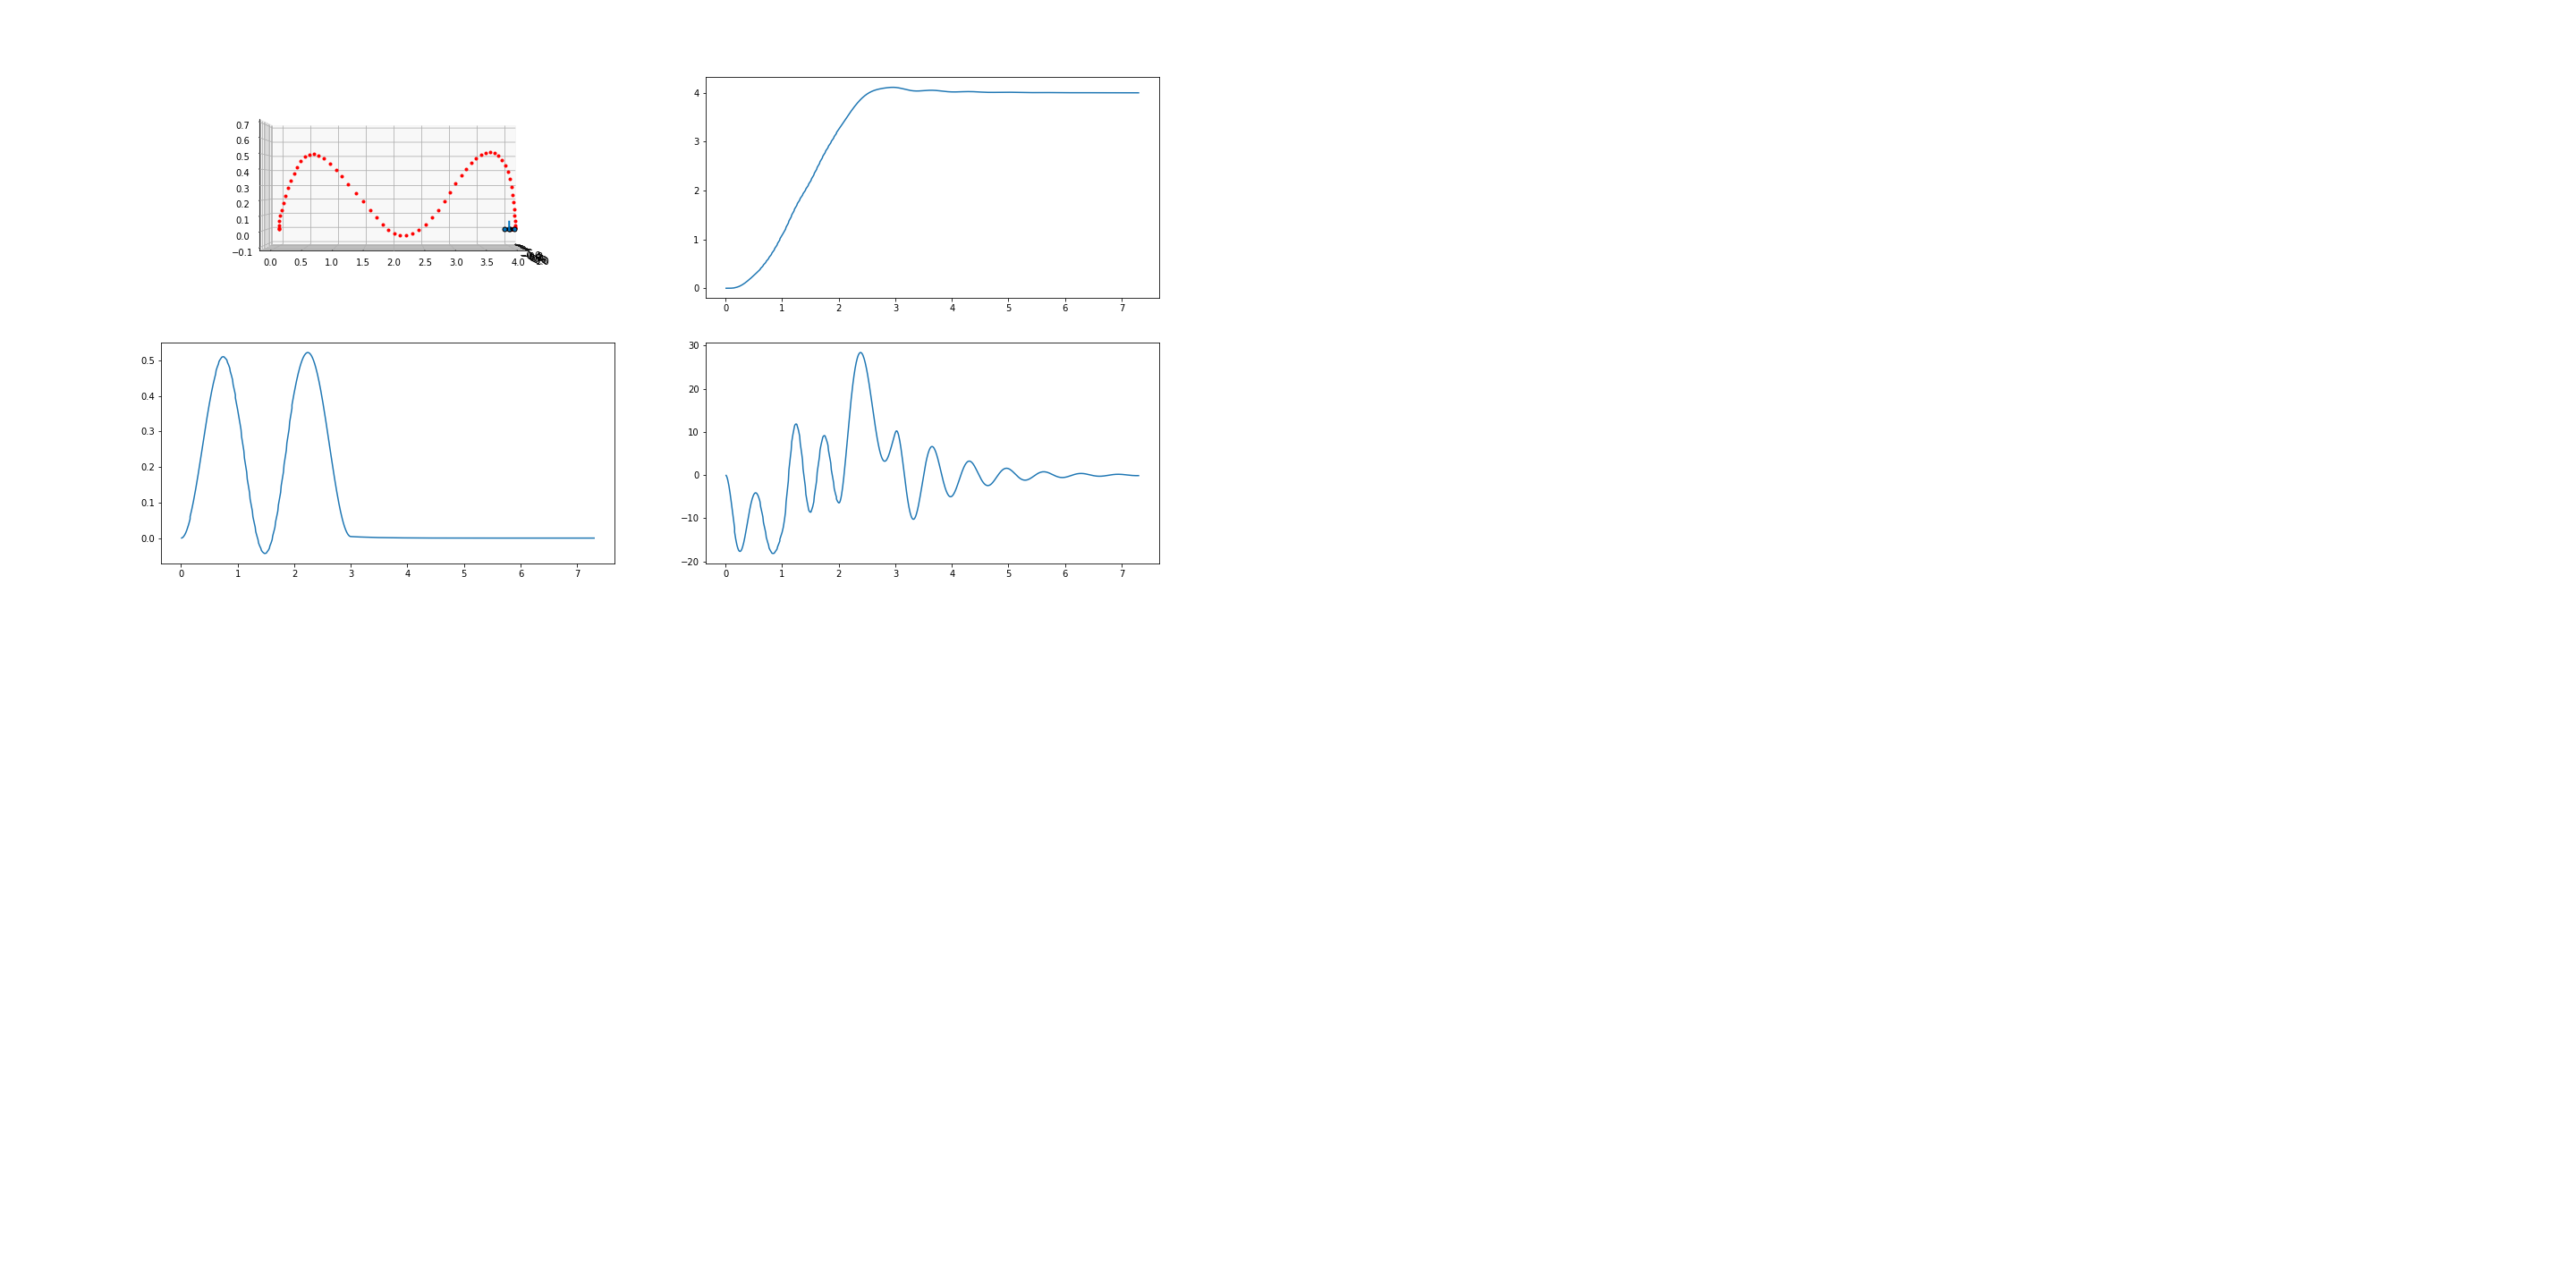

C:\Users\44754\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\44754\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\44754\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

KeyboardInterrupt: 

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
t,s = simulation_2d(controlhandle,trajhandle)